# Vamos construir um bloco de encoder completo estilo Transformer, incluindo:

- Multi-Head Attention
- Normalização
- Residual connections
- Feed-Forward Network (FFN)

Tudo isso com Keras Functional API em TensorFlow.

# 🔧 Construindo o Encoder Block do Transformer

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0 = all logs, 1 = info, 2 = warning, 3 = error

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model

import tensorflow as tf

def transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout=0.1, name="encoder_block"):
    # Inputs
    input_layer = Input(shape=(None, embed_dim), name=f"{name}_input")

    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, name=f"{name}_mha")(input_layer, input_layer)
    attention_output = Dropout(dropout)(attention_output)
    attention_residual = LayerNormalization(epsilon=1e-6)(input_layer + attention_output)

    # Feed-forward network
    ff_1 = Dense(ff_dim, activation="relu", name=f"{name}_ffn_1")(attention_residual)
    ff_2 = Dense(embed_dim, name=f"{name}_ffn_2")(ff_1)
    ff_output = Dropout(dropout)(ff_2)
    encoder_output = LayerNormalization(epsilon=1e-6)(attention_residual + ff_output)

    return Model(inputs=input_layer, outputs=encoder_output, name=name)


# 💡 Como usar:

Model: "encoder_block"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_block_input │ (None, None, 768) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_mha   │ (None, None, 768) │  2,362,368 │ encoder_block_in… │
│ (MultiHeadAttentio… │                   │            │ encoder_block_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 768) │          0 │ encoder_block_mh… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 768) │          0 │ encoder_block_in… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_ffn_1 │ (None, None,      │  2,362,368 │ layer_normalizat… │
│ (Dense)             │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_ffn_2 │ (None, None, 768) │  2,360,064 │ encoder_block_ff… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, None, 768) │          0 │ encoder_block_ff… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 768) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,087,872 (27.04 MB)

 Trainable params: 7,087,872 (27.04 MB)

 Non-trainable params: 0 (0.00 B)

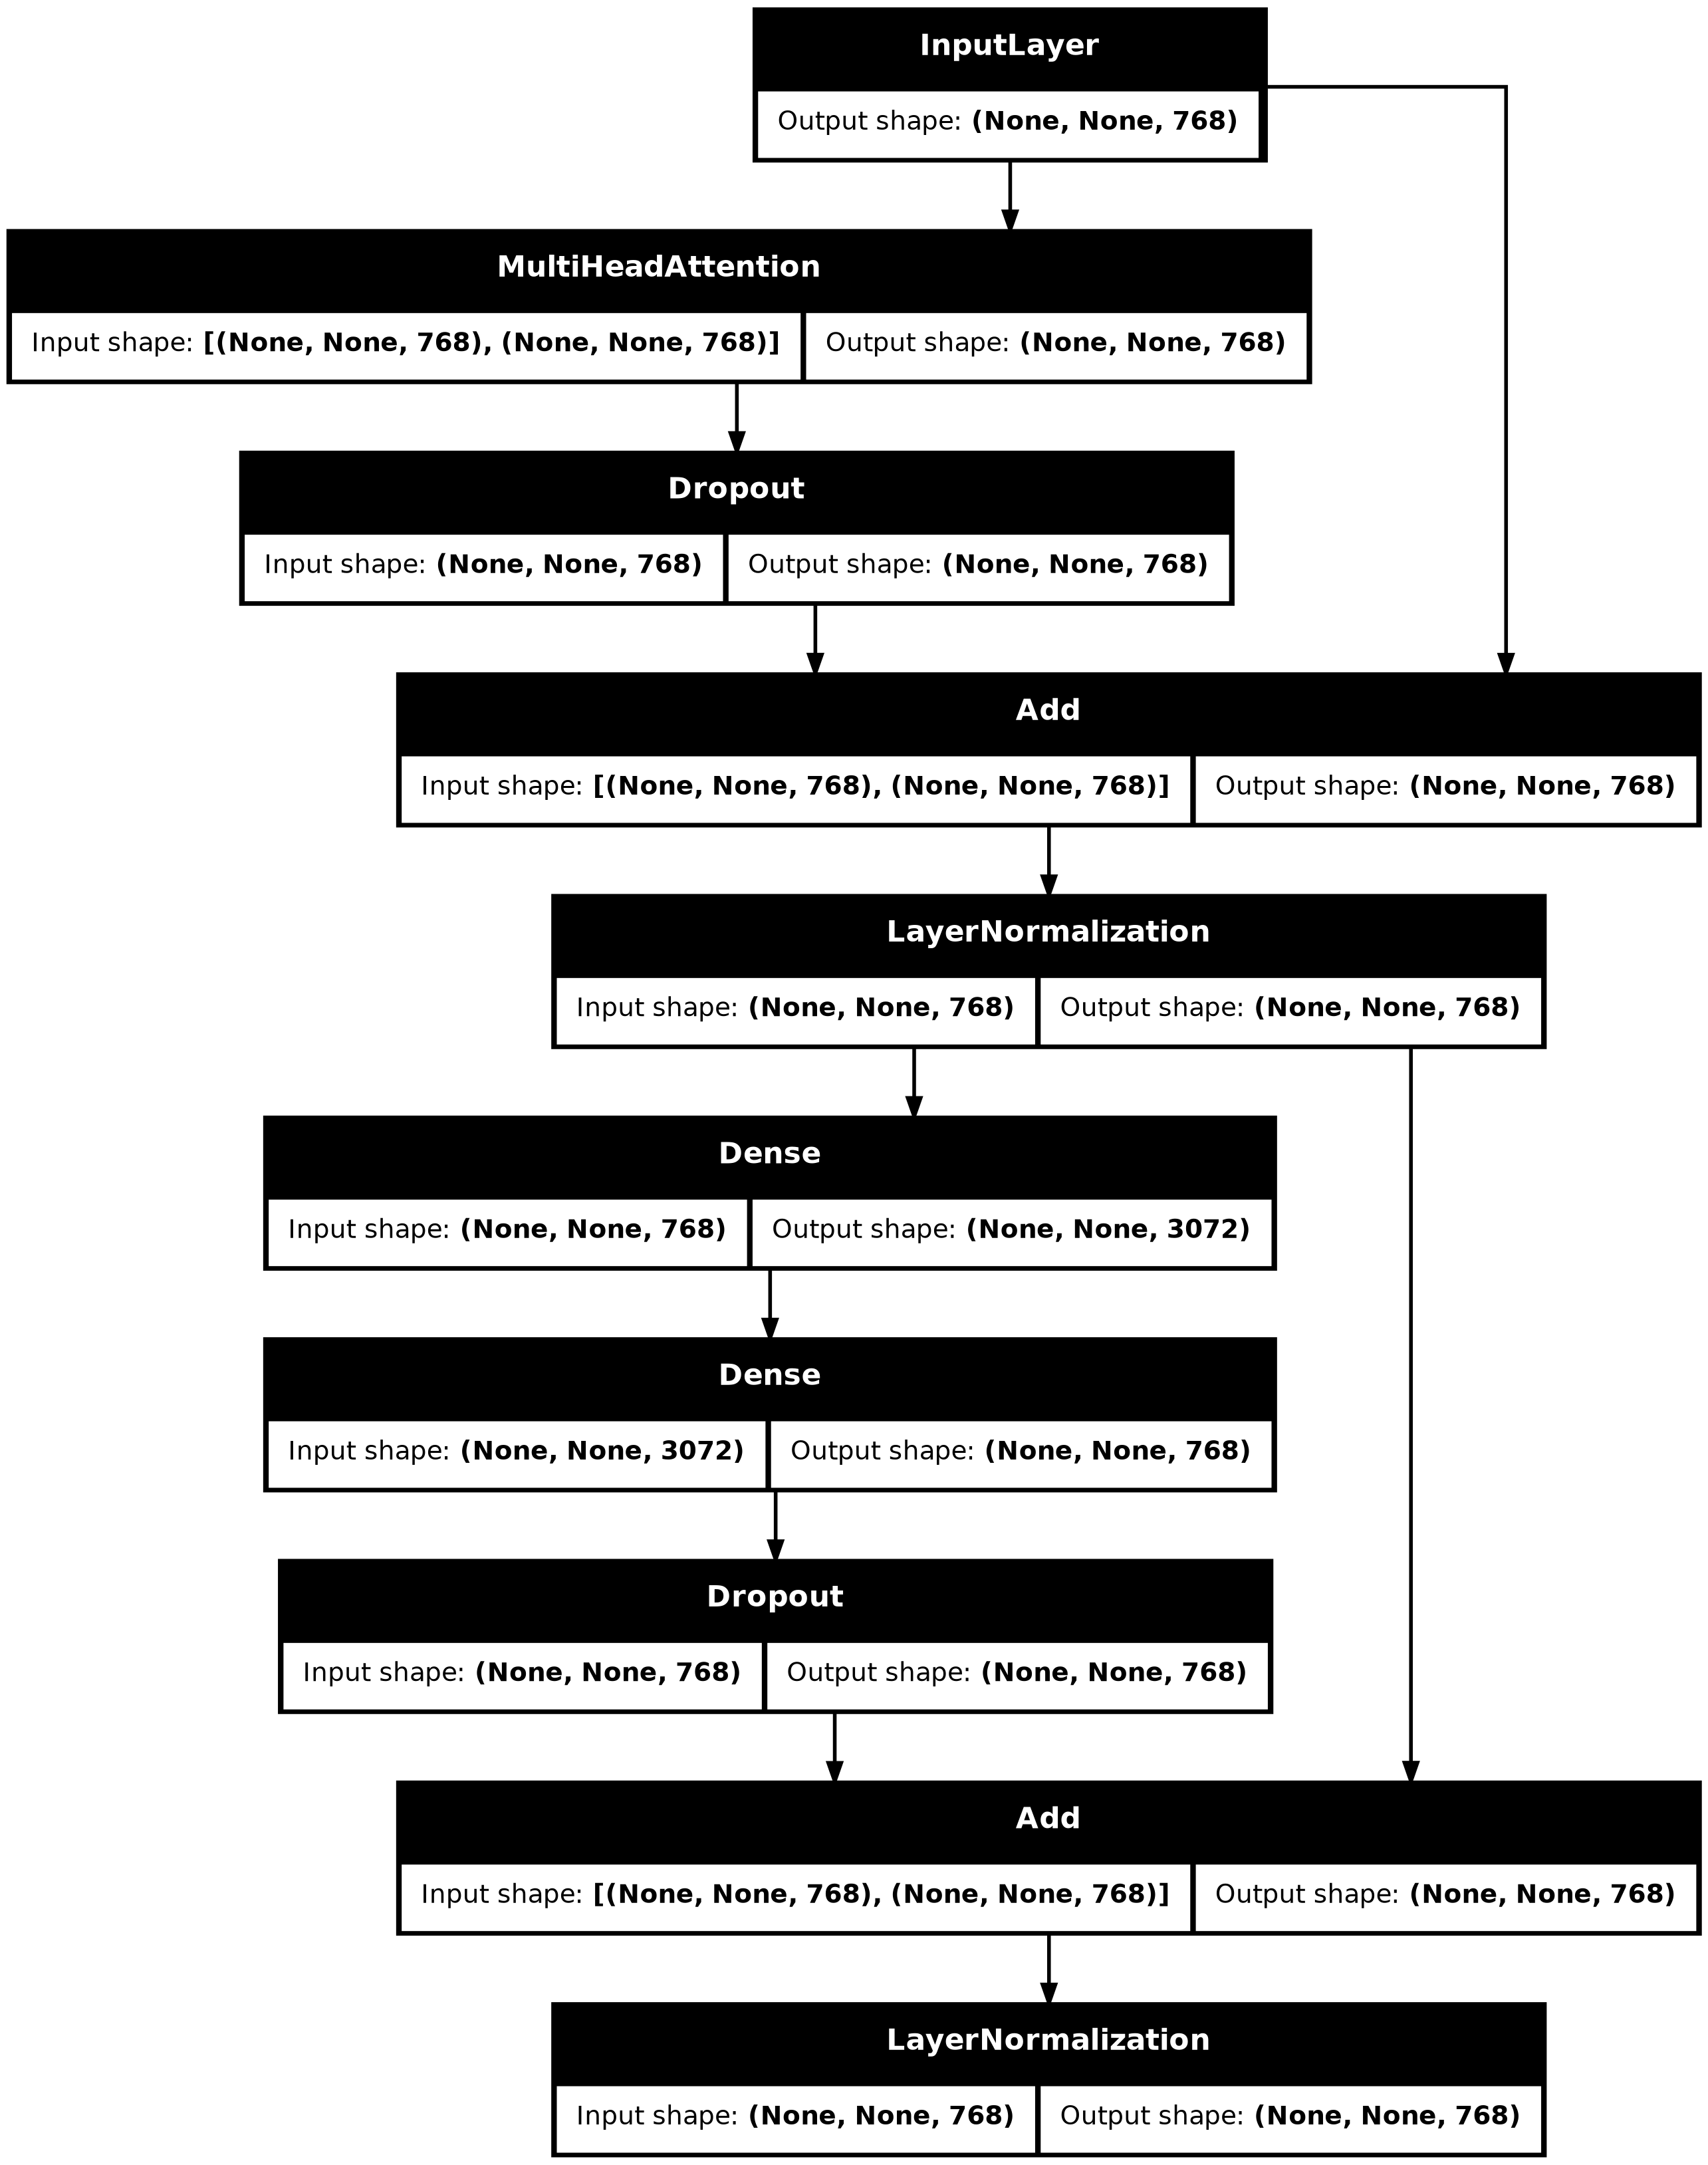

In [7]:
# Parâmetros típicos de um encoder BERT-like
embed_dim = 768       # Dimensão dos embeddings
num_heads = 12        # Número de cabeças de atenção
ff_dim = 3072         # Dimensão intermediária do FFN (geralmente 4x embed_dim)

# Cria o encoder block
encoder_block = transformer_encoder_block(embed_dim, num_heads, ff_dim)

# Visualiza
encoder_block.summary()
tf.keras.utils.plot_model(encoder_block, show_shapes=True, expand_nested=True)

# 🧠 O que esse bloco faz:


**Input → MHA → Residual → LayerNorm → FFN → Residual → LayerNorm**

é **a base da arquitetura Transformer**, exatamente como descrita no paper *"Attention is All You Need"*. Vamos ver o **porquê e como** cada parte funciona:

### 🔹 1. **Input → Multi-Head Attention (MHA)**

Aqui, a entrada (vetores de embeddings) passa por um mecanismo de **atenção com múltiplas cabeças**. Isso significa:

- **Cada cabeça de atenção** aprende a focar em diferentes aspectos dos tokens:
  - Uma pode focar em sintaxe (sujeito-verbo)
  - Outra pode olhar semântica (quem está fazendo o quê)

Saída: combinação dos contextos aprendidos por cada cabeça.

---

### 🔹 2. **Residual Connection (Skip connection)**

```python
x = input + attention_output
```

**Por que?**
- Ajuda no **fluxo do gradiente** (reduz o risco de *vanishing gradient*).
- Permite que a rede mantenha a **informação original da entrada**, útil se o bloco de atenção “errar”.

---

### 🔹 3. **Layer Normalization**

Normaliza a saída de cada token individualmente, para que:
- A **distribuição dos valores fique estável**.
- Facilite a **convergência durante o treinamento**.

📌 É diferente de *batch norm*: aqui normalizamos ao longo das dimensões de recursos (channels), não ao longo do batch.

---

### 🔹 4. **Feed-Forward Network (FFN)**

```python
FFN(x) = Dense(4 * d_model, relu) → Dense(d_model)
```

Essa é uma **MLP por token**, que:
- Aumenta temporariamente a dimensão (`4x d_model`)
- Passa por `ReLU`
- Reduz de volta para `d_model`

Serve para **misturar as informações** dentro de cada vetor de token (independente do tempo).

---

### 🔹 5. **Segunda Residual Connection + LayerNorm**

Novamente:
```python
x = input_ffn + output_ffn
x = LayerNormalization(x)
```

- **Skip connection** mantém a flexibilidade.
- **LayerNorm** estabiliza os valores antes de passar para o próximo encoder.

---

## 🎯 Resultado

Cada token da sequência é:
- **Recalculado com base no contexto dos outros tokens** (atenção)
- **Refinado individualmente** (feed-forward)
- Com **estabilidade e fluidez de aprendizado** (skip + norm)

---

## Última coisa! Vamos só explorar um aspecto fascinante e essencial do mecanismo de atenção:  

🔍 **Curiosidade Técnica: Por que usamos `Query`, `Key`, e `Value`?**

Na superfície, parece que o Transformer poderia simplesmente comparar vetores diretamente. Mas o uso explícito de **Query (Q)**, **Key (K)**, e **Value (V)** tem uma razão profunda:

---

### 🧠 **1. Separação de papéis**
- **Query (Q)**: o que está procurando por informação.
- **Key (K)**: "etiquetas" associadas a possíveis informações.
- **Value (V)**: a informação em si.

Essa separação permite que o modelo:
- Compare Q com K para calcular **quão relevante** é cada pedaço de informação.
- Use os pesos (atenção) para ponderar os V — ou seja, a **informação real**.

---

### 📐 **2. Arquitetura mais flexível**
Com Q, K e V separados, o Transformer pode:
- Ter múltiplas visões da entrada (ex: diferentes projeções lineares).
- Facilitar o **multi-head attention**, onde diferentes cabeças aprendem diferentes tipos de relações.

---

### 🔄 **3. Autocompletar, tradução e autocorrelação**
- Em **tradução**, Q pode vir da **frase-alvo**, enquanto K e V vêm da **frase de entrada** — isso permite que o modelo "busque" onde encontrar a tradução certa.
- Em **atenção causal**, a máscara impede Q de ver Ks futuros.

---

### 📊 Curiosidade visual: atenção é parecida com buscar na memória
Imagine Q como **uma pergunta** e K como **índices de um dicionário**, onde o modelo usa similaridade para decidir **quais valores (V)** deve "consultar".

---

### ✨ Dica prática: você pode visualizar isso!
Usando `bertviz` ou `captum` com PyTorch, você pode visualizar *quais palavras influenciam mais* outras — o que revela:
- Que "it" muitas vezes aponta para substantivos anteriores.
- Que cabeças diferentes codificam diferentes padrões gramaticais ou semânticos!